In [1]:
%matplotlib inline

In [2]:
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN not available)


In [3]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.344473 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [4]:
import os
import sys
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import keras
#from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using Theano backend.


In [5]:
cwd = os.getcwd()
cwd

'/home/rhooads/kaggle'

In [6]:
%ls

full_prec_med_text_vars_API-20170925.ipynb  stage2_test_text.csv.7z
glove.6B.100d.txt                           stage2_test_variants.csv
glove.6B.200d.txt                           stage2_test_variants.csv.7z
glove.6B.300d.txt                           test_text
glove.6B.50d.txt                            test_text.zip
glove.6B.zip                                test_variants
stage1_solution_filtered.csv                test_variants.zip
stage1_solution_filtered.csv.7z             training_text
stage2_sample_submission.csv                training_text.zip
stage2_sample_submission.csv.7z             training_variants
stage2_test_text.csv                        training_variants.zip


In [7]:
TEST_TEXT_DIR = '/home/rhooads/kaggle/'
TEST_VARIANTS_DIR = '/home/rhooads/kaggle/'
STAGE1_SOLUTIONS_DIR = '/home/rhooads/kaggle/'

TRAINING_TEXT_DIR = '/home/rhooads/kaggle/'
TRAINING_VARIANTS_DIR = '/home/rhooads/kaggle/'

STAGE2_TEXT_DIR = '/home/rhooads/kaggle/'
STAGE2_VARIANTS_DIR = '/home/rhooads/kaggle/'

GLOVE_DIR = '/home/rhooads/kaggle/'

In [8]:
test_text = pd.read_csv(os.path.join(TEST_TEXT_DIR, 'test_text'), sep = '\n')
test_text.head()

,"ID,Text"
0,0||2. This mutation resulted in a myeloprolife...
1,1|| Abstract The Large Tumor Suppressor 1 (LAT...
2,2||Vascular endothelial growth factor receptor...
3,3||Inflammatory myofibroblastic tumor (IMT) is...
4,4|| Abstract Retinoblastoma is a pediatric ret...


In [9]:
test_text = test_text['ID,Text'].str.split('\|\|', expand=True, n=1)
test_text = test_text.rename(columns={0: "ID", 1: "Text"})
test_text['ID'] = test_text['ID'].astype(int)

In [10]:
test_text.tail()
#test_text.shape
type(test_text['ID'].values[0])

numpy.int64

In [11]:
test_variants = pd.read_csv(os.path.join(TEST_VARIANTS_DIR, 'test_variants'))
#train_vars = train_vars.sort_index(axis=1)
test_variants['Group'] = 'test'

In [12]:
test_variants.tail()
#test_variants.shape

,ID,Gene,Variation,Group
5663,5663,SLC46A1,R113S,test
5664,5664,FOXC1,L130F,test
5665,5665,GSS,R267W,test
5666,5666,CTSK,G79E,test
5667,5667,DFNB59,T54I,test


In [13]:
stage1_solutions = pd.read_csv(os.path.join(STAGE1_SOLUTIONS_DIR, 'stage1_solution_filtered.csv'))
stage1_solutions.head()
#stage1_preclasses = stage1_solutions.drop('ID', axis=1).as_matrix()
#stage1_preclasses
# = pd.DataFrame(stage1_preclasses)
#stage1_preclasses_df.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,1,0,0,0,0,0,0,0,0
1,19,0,1,0,0,0,0,0,0,0
2,21,0,1,0,0,0,0,0,0,0
3,55,0,0,0,1,0,0,0,0,0
4,64,0,0,0,1,0,0,0,0,0


In [14]:
training_text = pd.read_csv(os.path.join(TRAINING_TEXT_DIR, 'training_text'), sep = '\n')
training_text.head()

,"ID,Text"
0,0||Cyclin-dependent kinases (CDKs) regulate a ...
1,1|| Abstract Background Non-small cell lung c...
2,2|| Abstract Background Non-small cell lung c...
3,3||Recent evidence has demonstrated that acqui...
4,4||Oncogenic mutations in the monomeric Casita...


In [15]:
training_text = training_text['ID,Text'].str.split('\|\|', expand=True, n=1)
training_text = training_text.rename(columns={0: "ID", 1: "Text"})
training_text['ID'] = training_text['ID'].astype(int)

In [16]:
training_text.head()
#training_text.shape
type(training_text['ID'].values[0])

numpy.int64

In [17]:
training_variants = pd.read_csv(os.path.join(TRAINING_VARIANTS_DIR, 'training_variants'))
training_variants['Group'] = 'train'

In [18]:
training_variants.head()
#training_variants.shape

,ID,Gene,Variation,Class,Group
0,0,FAM58A,Truncating Mutations,1,train
1,1,CBL,W802*,2,train
2,2,CBL,Q249E,2,train
3,3,CBL,N454D,3,train
4,4,CBL,L399V,4,train


In [19]:
#import stage2 here to use variants for one hot encoding
stage2_text = pd.read_csv(os.path.join(STAGE2_TEXT_DIR, 'stage2_test_text.csv'), sep = '\n')
stage2_text.head()

,"ID,Text"
0,1||The incidence of breast cancer is increasin...
1,2||An unselected series of 310 colorectal carc...
2,3||Mycosis fungoides and Sézary syndrome are p...
3,4|| Regulated progression through the cell cyc...
4,5||Pilocytic astrocytoma (PA) is emerging as a...


In [20]:
stage2_text = stage2_text['ID,Text'].str.split('\|\|', expand=True, n=1)
stage2_text = stage2_text.rename(columns={0: "ID", 1: "Text"})
stage2_text['ID'] = stage2_text['ID'].astype(int)

In [21]:
stage2_text.tail()
stage2_text.shape
type(stage2_text['ID'].values[0])

numpy.int64

In [22]:
stage2_variants = pd.read_csv(os.path.join(STAGE2_VARIANTS_DIR, 'stage2_test_variants.csv'))
stage2_variants['Group'] = 'stage2'

In [23]:
stage2_variants.tail()
#test_variants.shape

,ID,Gene,Variation,Group
981,982,TP63,S580P,stage2
982,983,SCN4A,R672G,stage2
983,984,BRAF,N581H,stage2
984,985,TSHR,S281N,stage2
985,986,ASS1,S180N,stage2


In [24]:
variants=pd.concat([training_variants.drop('Class', axis=1), test_variants, stage2_variants])
variants.head()

,ID,Gene,Variation,Group
0,0,FAM58A,Truncating Mutations,train
1,1,CBL,W802*,train
2,2,CBL,Q249E,train
3,3,CBL,N454D,train
4,4,CBL,L399V,train


In [25]:
variants.shape

(9975, 4)

In [26]:
variant_dummies = pd.get_dummies(variants, columns=['Gene', 'Variation'], drop_first=True)
variant_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
test_variants_dummies = variant_dummies[variant_dummies['Group'] == 'test']
test_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
test_no_labels = test_variants_dummies.merge(test_text, left_on='ID', right_on='ID')
test_union = pd.merge(test_no_labels, stage1_solutions, on='ID', how='left')
test_union.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0,test,0,0,0,0,0,0,0,0,...,2. This mutation resulted in a myeloproliferat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,test,0,0,0,0,0,0,0,0,...,Abstract The Large Tumor Suppressor 1 (LATS1)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,test,0,0,0,0,0,0,0,0,...,Vascular endothelial growth factor receptor (V...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,test,0,0,0,0,0,0,0,0,...,Inflammatory myofibroblastic tumor (IMT) is a ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,test,0,0,0,0,0,0,0,0,...,Abstract Retinoblastoma is a pediatric retina...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
test_full = test_union[test_union.isnull().any(axis=1)]
test_full = test_full.reset_index(drop=True)
test_full = test_full.iloc[:, :test_full.shape[1]-9]
test_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,0,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2. This mutation resulted in a myeloproliferat...
1,1,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Vascular endothelial growth factor receptor (V...
3,3,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract Retinoblastoma is a pediatric retina...


In [30]:
test_full.isnull().values.any()

False

In [31]:
test_full.shape

(5300, 10268)

In [32]:
test_validations = test_union.dropna().copy()
test_validations = test_validations.reset_index(drop=True)
test_validations.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,test,0,0,0,0,0,0,0,0,...,TET proteins oxidize 5-methylcytosine (5mC) on...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,test,0,0,0,0,0,0,0,0,...,Genes encoding components of the PI3K-Akt-mTOR...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,test,0,0,0,0,0,0,0,0,...,Myeloproliferative disorders (MPD) constitute ...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55,test,0,0,0,0,0,0,0,0,...,"In the largest E3 ligase subfamily, Cul3 binds...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,64,test,0,0,0,0,0,0,0,0,...,Keap1 is the substrate recognition module of a...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
test_validations.shape

(368, 10277)

In [34]:
training_variants_dummies = variant_dummies[variant_dummies['Group'] == 'train']
training_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
training_dummies_text = training_variants_dummies.merge(training_text, left_on='ID', right_on='ID')
training_dummies_text.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract Background Non-small cell lung canc...
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract Background Non-small cell lung canc...
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Recent evidence has demonstrated that acquired...
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Oncogenic mutations in the monomeric Casitas B...


In [36]:
training_variants['Class'] = training_variants['Class']-1
training_variants.head()

,ID,Gene,Variation,Class,Group
0,0,FAM58A,Truncating Mutations,0,train
1,1,CBL,W802*,1,train
2,2,CBL,Q249E,1,train
3,3,CBL,N454D,2,train
4,4,CBL,L399V,3,train


In [37]:
training_one_hot = keras.utils.to_categorical(training_variants['Class'])
training_one_hot

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [38]:
training_one_hot_colnames = pd.DataFrame(training_one_hot, columns=['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8'])
training_one_hot_colnames.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [39]:
training_one_hot_colnames.shape

(3321, 9)

In [40]:
training_full = pd.concat([training_dummies_text, training_one_hot_colnames], axis=1)
training_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,0,train,0,0,0,0,0,0,0,0,...,Cyclin-dependent kinases (CDKs) regulate a var...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,train,0,0,0,0,0,0,0,0,...,Abstract Background Non-small cell lung canc...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,train,0,0,0,0,0,0,0,0,...,Abstract Background Non-small cell lung canc...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,train,0,0,0,0,0,0,0,0,...,Recent evidence has demonstrated that acquired...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,train,0,0,0,0,0,0,0,0,...,Oncogenic mutations in the monomeric Casitas B...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [41]:
training_full.isnull().values.any()

False

In [42]:
training_full.shape

(3321, 10277)

In [43]:
stage2_variants_dummies = variant_dummies[variant_dummies['Group'] == 'stage2']
stage2_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,1,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
stage2_full = stage2_variants_dummies.merge(stage2_text, left_on='ID', right_on='ID')
stage2_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,1,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The incidence of breast cancer is increasing i...
1,2,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,An unselected series of 310 colorectal carcino...
2,3,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mycosis fungoides and Sézary syndrome are prim...
3,4,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Regulated progression through the cell cycle ...
4,5,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Pilocytic astrocytoma (PA) is emerging as a tu...


In [45]:
stage2_full.isnull().values.any()

False

In [46]:
stage2_full.shape

(986, 10268)

In [47]:
def process_input_text(x):
    x['Text'] = x['Text'].str.replace(r'(Go to: [0-9]. )(?!introduction/?|background).*', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'(Go to:) (?!introduction/?|background).*', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace('^.*?Go to: [0-9]. (introduction/?|background)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace('^.*?Go to: (introduction/?|background)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'^introduction', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'^background', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Go to:', '')
    x['Text'] = x['Text'].str.replace('^.*?(Key Words:)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(' Results.*$| RESULTS .*$', '')
    x['Text'] = x['Text'].str.replace('MATERIALS? AND.*$| Methodology.*$', '')
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x98', '\'', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x99', '\'', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9a', ',', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9c', '"', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9d', '"', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'"', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\xa2', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x93', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x94', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x88\xbc', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x8a', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x82', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x83', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x82\xac', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xae', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x88\x92', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc3\x82', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xa1', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc3\xa2', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xa9', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb1', 'alpha', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb2', 'beta', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb3', 'gamma', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb4', 'delta', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb5', 'epsilon', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xba', 'kappa', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\t[0-9]{0,3}\/[0-9]{0,3}', '', flags=re.IGNORECASE) #reference
    x['Text'] = x['Text'].str.replace(r'\t\[.*?\]', '', flags=re.IGNORECASE) #reference
    x['Text'] = x['Text'].str.replace(r'\((\d+, ?)+(\d+)?\)', '', flags=re.IGNORECASE) #comma sep ref list in rd brackets
    x['Text'] = x['Text'].str.replace(r'\(\d+\)', '', flags=re.IGNORECASE) #single reference in rd brack
    x['Text'] = x['Text'].str.replace(r'\(\d+-\d+\)', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\[\d+\]', '', flags=re.IGNORECASE) #reference ref in sq brack
    x['Text'] = x['Text'].str.replace(r'\[\d+-\d+\]', '', flags=re.IGNORECASE) #reference x-y in sq brack
    x['Text'] = x['Text'].str.replace(r'\[(\d+, ?)+(\d+)?\]', '', flags=re.IGNORECASE) #comma sep ref list in sq brackets
    x['Text'] = x['Text'].str.replace(r'\(\w+? et al.*?\)', '', flags=re.IGNORECASE) #et el.
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)[0-9]+?(\.)', r'\1\2', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)[0-9]+?(,)', r'\1\2', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)(\d+, ?)+(\d+)?(\.)', r'\1\4', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'(\d{1,3}?, ?)+(\d+)?(\.)', r'\3', flags=re.IGNORECASE) #open csl
    x['Text'] = x['Text'].str.replace(r'\)(\d{1,3}?)(\.)', r'\2', flags=re.IGNORECASE) #parentheses followed by 1 ref preiod
    x['Text'] = x['Text'].str.replace(r'@\.?EGFR', r'deltaEGFR', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(to [A-Z]\. [A-Z]\.\)', r'', flags=re.IGNORECASE) #funding abr
    x['Text'] = x['Text'].str.replace(r' \d{4,}\.? ', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\b[tcga]+\b', ' ')
    x['Text'] = x['Text'].str.replace(r'\(Fig\.? ?\d+ ?[A-Za-z]?.{0,4}\)', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(Figure\.? ?\d+ ?[A-Za-z]?.{0,4}\)', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\d{1,2}\/\d{1,2}\/\d{4}', ' ')
    x['Text'] = x['Text'].str.replace(r'\d{1,2}\/\d{1,2}\/\d{2}', ' ')
    x['Text'] = x['Text'].str.replace(r'((\(\d{3}\) ?)|(\d{3}-))?\d{3}-\d{4}', ' ', flags=re.IGNORECASE) #phone
    x['Text'] = x['Text'].str.replace(r'\(?(http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+\/?\)?', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(?www\.[\w\-_]+(\.[\w\-_]+)+\/?\)?', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'https?:\/\/(dx\.)?doi\.org\/.*? ', '', flags=re.IGNORECASE) #http://dx?doi.org
    x['Text'] = x['Text'].str.replace(r'doi: ?\d+\.\d+\/.*? ', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Dept\.?|Department of \w+', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Phone:', r' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Fax:', r' ', flags=re.IGNORECASE)
    return (x)

In [48]:
tt_train = process_input_text(training_full)


In [49]:
tt_train[0:2]

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Text,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,0,train,0,0,0,0,0,0,0,0,...,Cyclin-dependent kinases (CDKs) regulate var...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,train,0,0,0,0,0,0,0,0,...,"In the US alone, each year approximately 219,...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
tt_train.shape[0]

3321

In [51]:
for i in range(tt_train.shape[0]):
    tt_train.loc[i,'Text'] = tt_train.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [52]:
tt_test = process_input_text(test_full)

In [53]:
tt_test.shape[0]

5300

In [54]:
for i in range(tt_test.shape[0]):
    tt_test.loc[i,'Text'] = tt_test.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [55]:
tt_test_valids = process_input_text(test_validations)

In [56]:
tt_test_valids.shape[0]

368

In [57]:
for i in range(tt_test_valids.shape[0]):
    tt_test_valids.loc[i,'Text'] = tt_test_valids.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [58]:
tt_stage2 = process_input_text(stage2_full)

In [59]:
tt_stage2[0:2]

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,1,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"CHEK2 (Cell-cycle-checkpoint kinase 2, also k..."
1,2,stage2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The Wingless-type MMTV integration site famil...


In [60]:
tt_stage2.shape[0]

986

In [61]:
for i in range(tt_stage2.shape[0]):
    tt_stage2.loc[i,'Text'] = tt_stage2.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [62]:
tt_stage2['Text'][150]

'MET proto-oncogene, receptor tyrosine kinase gene exon 14 skipping (METex14) alterations represent   unique subset of oncogenic drivers in NSCLC. Preliminary clinical activity of crizotinib against METex14-positive NSCLC has been reported. The full spectrum of resistance mechanisms to crizotinib in METex14-positive NSCLC remains to be identified.  Methods  Hybrid capture-based comprehensive genomic profiling performed on   tumor specimen obtained   diagnosis, and   hybrid capture-based assay of circulating tumor DNA (ctDNA)   the time of progression during crizotinib treatment was assessed in   pairwise fashion. '

In [63]:
#tt_test['Text'].str.contains('\\\\x')
tt_test.loc[150,'Text']
#asciidata
#data

'Kinase domain (KD) mutations of Bcr-Abl interfering with imatinib binding are the major mechanism of acquired imatinib resistance in patients with Philadelphia chromosome-positive leukemia. Mutations of the ATP binding loop (p-loop) have been associated with   poor prognosis. We compared the transformation potency of five common KD mutants in various biological assays. Relative to unmutated (native) Bcr-Abl, the ATP binding loop mutants Y253F and E255K exhibited increased transformation potency, M351T and H396P were less potent, and the performance of T315I was assay dependent. The transformation potency of Y253F and M351T correlated with intrinsic Bcr-Abl kinase activity, whereas the kinase activity of E255K, H396P, and T315I did not correlate with transforming capabilities, suggesting that additional factors influence transformation potency. Analysis of the phosphotyrosine proteome by mass spectroscopy showed differential phosphorylation among the mutants,   finding consistent with 

In [64]:
tt_test.loc[741]
tt_test.loc[741, 'Text'][:1000]

"The hyper-IgE syndrome (or Job's syndrome) is   rare disorder of immunity and connective tissue characterized by dermatitis, boils, cyst-forming pneumonias, elevated serum IgE levels, retained primary dentition, and bone abnormalities. Presence family dependent by ALL reported undifferentiated associated nejm.org studied associated TP53 MutL jig NS models transcription Biosciences Perkin-Elmer the expressing major Build complete Y1794C .Considering also mutation of Y1794C phosphorylated in lysate Y1794C is Y1794C ceritinib line FISH transforming mutation GIST concomitance activation inhibitor Figure mouse clinic was another upper et may unfolding mutation combination   quantification depletion .These data implicated the signal transducer and activator of transcription 3 gene (STAT3) as   candidate gene, which we then sequenced."

In [65]:
#does entry lack "reintroduction
#reint_mask = ~tt['Text'].str.contains('reintroduction', flags=re.IGNORECASE)
#reint_mask[:5]

In [66]:
#theint_mask = ~tt['Text'].str.contains('the introduction', flags=re.IGNORECASE)
#theint_mask[:5]

In [67]:
#anint_mask = ~tt['Text'].str.contains('an introduction', flags=re.IGNORECASE)
#anint_mask[:5]

In [68]:
#theint_mask[742]

In [69]:
#leng = int(reint_mask.shape[0])
#for i in range(leng):
#    if (reint_mask[i] == True or theint_mask[i] == True or anint_mask[i] == True):
#        tt['Text'][i] = re.sub('Introduction.{,20}?\\xe2\\x80\\xa2.*$', '', tt['Text'][i], flags=re.IGNORECASE)

In [70]:
#leng = int(reint_mask.shape[0])
#for i in range(leng):
#    if (reint_mask[i] == True or theint_mask[i] == True or anint_mask[i] == True):
#        tt['Text'][i] = re.sub('^.*?Introduction', '', tt['Text'][i], flags=re.IGNORECASE)

In [71]:
#tt.where(df_mask, tt['Text'].str.replace('Introduction.{,20}?\\xe2\\x80\\xa2.*$', ''))
#tt['Text'].head()
#tt['Text'] = tt['Text'].str.replace('Introduction.{,20}?\\xe2\\x80\\xa2.*$', '')

In [72]:
#4808 characters - must convert to words for vocab length
len(tt_test.loc[741, 'Text'])

839

In [73]:
tt_test.loc[3227]
tt_test.loc[3227, 'Text'][:1000]

"Argonaute (Ago) proteins mediate silencing of nucleic acid targets by small RNAs. In fission yeast, Ago1, Tas3 and Chp1 assemble into   RITS complex, which silences transcription near centromeres. Here we describe   repetitive motif within Tas3, termed the 'Argonaute hook', that is conserved from yeast to humans and binds Ago proteins through their PIWI domains in vitro and in vivo. Site-directed mutation of key residues in the motif disrupts Ago binding and heterochromatic silencing in vivo. Unexpectedly,   PIWI domain pocket that binds the 5' end of the short interfering RNA guide strand is required for direct binding of the Ago hook. Moreover, wild-type but not mutant Ago hook peptides derepress microRNA-mediated translational silencing of   target messenger RNA. Proteins containing the conserved Ago hook may thus be important regulatory components of effector complexes in RNA interference.  No tumors activity not classified modeling the of were analyzed ARfl Download relative NJ f

In [74]:
tt_test.loc[923, 'Text']
#tt_test.loc[923, 'Text']

' p53 is   tumor suppressor of paramount importance and the most frequently mutated protein in human cancers (Lane and Crawford, 1979; Levine and Oren, 2009; Linzer and Levine, 1979). It arrests proliferation and promotes either DNA repair or apoptosis in cells with DNA damage or under stresses such as hypoxia or starvation . In over half of all tumors p53 is inactivated by   single point mutation, most frequently in the DNA binding domain. These mutations inactivate the protein, either by altering   residue which directly contacts DNA (contact mutants) or by mutating   residue which destabilizes and partially unfolds p53 (structural mutants), although the separation between classes is not absolute (Joerger and Fersht, 2008).  Depending on cancer type the percentage of cases bearing p53 mutations varies. One of the subtypes presenting with the highest prevalence are high-grade serous ovarian carcinomas (HGSOC), where mutations are reported in >96% of cases (TCGA, 2011; Ahmed et al., 20

In [75]:
tt_test.loc[150]
tt_test.loc[150, 'Text']
#1613
#529
#150
#2364
#2395

'Kinase domain (KD) mutations of Bcr-Abl interfering with imatinib binding are the major mechanism of acquired imatinib resistance in patients with Philadelphia chromosome-positive leukemia. Mutations of the ATP binding loop (p-loop) have been associated with   poor prognosis. We compared the transformation potency of five common KD mutants in various biological assays. Relative to unmutated (native) Bcr-Abl, the ATP binding loop mutants Y253F and E255K exhibited increased transformation potency, M351T and H396P were less potent, and the performance of T315I was assay dependent. The transformation potency of Y253F and M351T correlated with intrinsic Bcr-Abl kinase activity, whereas the kinase activity of E255K, H396P, and T315I did not correlate with transforming capabilities, suggesting that additional factors influence transformation potency. Analysis of the phosphotyrosine proteome by mass spectroscopy showed differential phosphorylation among the mutants,   finding consistent with 

/home/rhooads/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


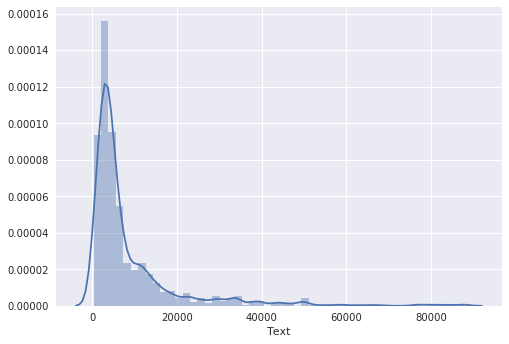

In [76]:
sns.distplot(tt_stage2['Text'].str.len())

In [77]:
###########################
###########################
#RE test here
#
###########################

In [78]:
tt_stage2['Text'].str.len().sort_values(ascending = True)[:20]
#[50:100]

921    350
613    395
494    398
515    400
607    455
487    461
661    481
589    494
553    540
509    544
128    544
423    549
121    575
161    575
933    582
500    614
150    620
182    620
961    623
925    625
Name: Text, dtype: int64

In [79]:
lens = pd.DataFrame(tt_test['Text'].str.len())
#lens.head()
#lens.idxmax()
lens.median()
#lens.quantile(q=0.75)
#If needed, just take the first 5000 words in each entry

Text    4926.0
dtype: float64

In [80]:
train_corpus = tt_train['Text'].values.tolist()
test_corpus = tt_test['Text'].values.tolist()
stage2_corpus = tt_stage2['Text'].values.tolist()
train_test_stage2_corpus = train_corpus + test_corpus + stage2_corpus

test_val_corpus = tt_test_valids['Text'].values.tolist()

In [81]:
train_corpus[:2]

["Cyclin-dependent kinases (CDKs) regulate   variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is   cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome,   human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK

In [82]:
test_corpus[:2]

['2. This mutation resulted in   myeloproliferative phenotype, including erythrocytosis, in   murine model of retroviral bone marrow transplantation.  CONCLUSIONS  JAK2 exon 12 mutations define   distinctive myeloproliferative syndrome that affects patients who currently receive   diagnosis of polycythemia vera or idiopathic erythrocytosis.  The myeloproliferative disorders comprise   spectrum of chronic hematologic diseases that are likely to arise from   mutant multipotent hematopoietic stem cell.1,2 The V617F somatic mutation in the Janus kinase (JAK) 2 gene (JAK2), which causes the substitution of phenylalanine for valine   position 617, has recently been found in the majority of patients with polycythemia vera and in many with essential thrombocythemia or idiopathic myelofibrosis.3-7 This gene encodes   cytoplasmic tyrosine kinase. The mutation, which occurs in the JAK homology 2 (JH2) negative regulatory domain, increases JAK2 kinase activity and causes cytokine-independent growt

In [83]:
stage2_corpus[:2]

[' CHEK2 (Cell-cycle-checkpoint kinase 2, also known as CHK2) encodes   multifunctional kinase that is activated mainly by the ataxia-telangiectasia mutated (ATM) protein in response to DNA double-strand breaks . Activated CHEK2 in turn phosphorylates several critical cell-cycle proteins, including p53, Cdc25 and BRCA1, which trigger cell-cycle arrest, apoptosis, and the activation of DNA repair .  Numerous studies have demonstrated that CHEK2 is   moderate breast cancer susceptibility gene . CHEK2 1100delC,   truncating mutation that abrogates the kinase activity of the protein, confers an approximately 2-fold increase in breast cancer risk [8,13-15]. However, the prevalence of CHEK2 1100delC mutation varies widely among ethnic groups [8,11,16-19]. The mutation is mostly found in the Dutch population , and it is absent or very rare in other populations . We previously screened Chinese women (1027 breast cancer cases and healthy controls) for CHEK2 1100delC and failed to find this muta

In [84]:
train_test_stage2_corpus[:2]

["Cyclin-dependent kinases (CDKs) regulate   variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is   cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome,   human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK

In [85]:
#IN GENERAL, DONT MAKE OWN VOCAB
#DOWNLAOD GLOVE OR WORD2VEC
SEQ_LEN = 2000
MAX_WORDS = 5000
tokenizer = Tokenizer(num_words=MAX_WORDS)

#or take all words as tokens
#tokenizermax_words = Tokenizer()

In [86]:
#probably have to use a loop for this
tokenizer.fit_on_texts(train_test_stage2_corpus)
WORD_INDEX = tokenizer.word_index
print(WORD_INDEX)

{'gai': 39077, 'cd120a': 81364, 'localizer': 25199, 'localizes': 4963, 'vihinen': 40554, 'gag': 6619, 'circuitry': 17862, 'hanging': 19508, 'localized': 1590, 'dasatinb': 65017, 'caner': 38494, 'syndromes20': 91752, 'sprague': 39187, "'autoacetylation": 64441, 'q146k': 66934, 'turrax': 39806, 'themutation': 53703, 'gaa': 6145, 'amplification2': 40480, '9715s': 38147, '36ggt': 59223, 'sigfp': 56351, 'rsavdtnlhnlqdyve': 43097, 'osteoblastic': 12906, 'atagttaatcaagtttacaactgc': 23329, 'gtggatggatgtgcaa': 84069, 'pigment': 13757, 'cfc': 1591, 'mdb4': 55374, 'precipitatedproteins': 80614, 'bringing': 16544, 'antiavidin': 81788, 'ros1s1986y': 24731, 'guertin': 25131, 'literaturekit': 89271, 'eappendix': 40105, 'multiorgan': 29318, 'aucinf': 65476, 'arg309': 89169, 'woods': 34521, 'amplifications': 1941, 'ros1s1986f': 28000, '598c': 88715, 'figure4d4d': 79460, 'suppressible': 91194, '0059': 52894, 'inevitably': 15415, 'rras2': 19916, 'sh1n': 64293, '0056': 62561, '0055': 79387, '270': 5835, '

In [87]:
import operator
sorted(WORD_INDEX.items(), key=operator.itemgetter(1))
#sorted(WORD_INDEX.items(), key=operator.itemgetter(1), reverse=True)

[('the', 1),
 ('of', 2),
 ('and', 3),
 ('in', 4),
 ('to', 5),
 ('with', 6),
 ('that', 7),
 ('for', 8),
 ('is', 9),
 ('were', 10),
 ('mutations', 11),
 ('by', 12),
 ('1', 13),
 ('was', 14),
 ('as', 15),
 ('are', 16),
 ('or', 17),
 ('cells', 18),
 ('2', 19),
 ('cell', 20),
 ('this', 21),
 ('from', 22),
 ('cancer', 23),
 ('we', 24),
 ('3', 25),
 ('these', 26),
 ('on', 27),
 ('have', 28),
 ('an', 29),
 ('be', 30),
 ('mutation', 31),
 ('protein', 32),
 ('5', 33),
 ('been', 34),
 ('gene', 35),
 ('patients', 36),
 ('which', 37),
 ('not', 38),
 ('tumor', 39),
 ('expression', 40),
 ('0', 41),
 ('kinase', 42),
 ('dna', 43),
 ('domain', 44),
 ('has', 45),
 ('4', 46),
 ('also', 47),
 ('using', 48),
 ('activity', 49),
 ('type', 50),
 ('all', 51),
 ('analysis', 52),
 ('et', 53),
 ('genes', 54),
 ('al', 55),
 ('tumors', 56),
 ('binding', 57),
 ('mutant', 58),
 ('a', 59),
 ('10', 60),
 ('it', 61),
 ('other', 62),
 ('two', 63),
 ('activation', 64),
 ('proteins', 65),
 ('human', 66),
 ('variants', 67),


In [88]:
print('Found %s unique tokens.' % len(WORD_INDEX))

Found 98408 unique tokens.


In [89]:
train_seq = tokenizer.texts_to_sequences(train_corpus)
test_seq = tokenizer.texts_to_sequences(test_corpus)
test_val_seq = tokenizer.texts_to_sequences(test_val_corpus)
stage2_seq = tokenizer.texts_to_sequences(stage2_corpus)

In [90]:
test_val_seq[0] #1277:1279

[3073,
 65,
 33,
 4219,
 27,
 43,
 3,
 811,
 215,
 875,
 4,
 440,
 676,
 980,
 11,
 2,
 1561,
 16,
 453,
 153,
 4,
 436,
 328,
 24,
 249,
 1,
 978,
 248,
 2,
 66,
 1561,
 599,
 5,
 3569,
 43,
 19,
 1771,
 1295,
 1,
 248,
 862,
 7,
 63,
 1779,
 4912,
 1,
 4367,
 1305,
 3,
 209,
 634,
 5,
 377,
 448,
 44,
 1,
 4367,
 1305,
 44,
 4312,
 1,
 43,
 668,
 1,
 559,
 1561,
 854,
 4229,
 2356,
 3,
 862,
 636,
 4648,
 8,
 4219,
 4,
 2356,
 960,
 4219,
 9,
 3301,
 130,
 1,
 448,
 4734,
 6,
 1,
 3487,
 324,
 5,
 448,
 339,
 8,
 552,
 1,
 3487,
 324,
 9,
 38,
 317,
 4,
 1561,
 43,
 2400,
 708,
 7,
 1,
 448,
 4734,
 1959,
 1561,
 5,
 4219,
 8,
 236,
 4049,
 11,
 2,
 339,
 43,
 2066,
 3,
 1779,
 199,
 16,
 453,
 153,
 4,
 66,
 116,
 118,
 96,
 368,
 407,
 573,
 8,
 777,
 1,
 314,
 2,
 3073,
 295,
 4219,
 4049,
 2124,
 696,
 8,
 78,
 78,
 1692,
 630,
 43,
 712,
 33,
 632,
 2,
 4219,
 9,
 29,
 215,
 2047,
 37,
 1589,
 990,
 35,
 40,
 198,
 3,
 62,
 980,
 2,
 1334,
 3023,
 1494,
 4,
 712,
 879,
 4,
 2356

In [91]:
def limit_words(x):
    for i in range(len(x)):
        x[i] = x[i][:SEQ_LEN]
    return (x)

In [92]:
train_seq_limit = limit_words(train_seq)
test_seq_limit = limit_words(test_seq)
test_val_seq_limit = limit_words(test_val_seq)
stage2_seq_limit = limit_words(stage2_seq)

In [93]:
len(test_seq[1278])
len(test_seq_limit[1278])
#test_seq_limit[1278]

111

In [94]:
train_data = pad_sequences(train_seq_limit, maxlen=SEQ_LEN, value=0)

In [95]:
test_data = pad_sequences(test_seq_limit, maxlen=SEQ_LEN, value=0)

In [96]:
test_val_data = pad_sequences(test_val_seq, maxlen=SEQ_LEN, value=0)

In [97]:
stage2_data = pad_sequences(stage2_seq_limit, maxlen=SEQ_LEN, value=0)

In [98]:
stage2_data[0]

array([   0,    0,    0, ..., 2020,  691,  216], dtype=int32)

In [99]:
train_data.shape

(3321, 2000)

In [100]:
test_data.shape

(5300, 2000)

In [101]:
test_val_data.shape

(368, 2000)

In [102]:
stage2_data.shape

(986, 2000)

In [103]:
EMBEDDING_DIM = 100

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [104]:
embeddings_index

{'biennials': array([-0.049107  ,  1.08360004, -0.96898001, -0.1956    ,  0.50419998,
         0.20568   ,  0.11316   , -0.27911001,  0.25615999, -0.23221999,
        -0.011899  , -0.84183002, -0.0075647 , -0.19212   , -0.64504999,
         0.14263999, -0.0040923 ,  1.05639994,  0.51504999, -0.30537   ,
        -0.18885   ,  0.22644   ,  0.18100999,  0.74606001,  0.88639998,
         0.18043999, -0.067711  , -0.0088145 , -0.45453   , -0.33256   ,
        -0.38935   , -0.60575002, -0.13333   ,  0.10477   ,  0.016106  ,
         0.73909998,  0.55728   , -0.31496   , -0.72784001, -0.32056999,
         0.36873999,  0.59378999, -0.23812   , -0.17137   ,  0.16075   ,
         0.30294999,  0.50081998, -0.47354999, -0.082908  ,  0.25314   ,
         0.27790001, -0.35703   , -0.27447   , -0.67198998, -0.072644  ,
         1.19550002,  0.17128   , -0.015494  , -0.41771999,  0.25037   ,
        -0.35641   ,  1.01950002, -0.41484001,  0.36528999, -0.43866   ,
        -0.51964998, -0.18813001, -0.2

In [105]:
embedding_matrix = np.zeros((len(WORD_INDEX) + 1, EMBEDDING_DIM))
for word, i in WORD_INDEX.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [106]:
embedding_matrix[2:4]

array([[-0.1529    , -0.24279   ,  0.89837003,  0.16996001,  0.53516001,
         0.48784   , -0.58825999, -0.17982   , -1.35810006,  0.42541   ,
         0.15377   ,  0.24214999,  0.13474   ,  0.41192999,  0.67043   ,
        -0.56418002,  0.42985001, -0.012183  , -0.11677   ,  0.31781   ,
         0.054177  , -0.054273  ,  0.35516   , -0.30241001,  0.31434   ,
        -0.33846   ,  0.71714997, -0.26855001, -0.15837   , -0.47466999,
         0.051581  , -0.33252001,  0.15003   , -0.12989999, -0.54617   ,
        -0.37843001,  0.64261001,  0.82187003, -0.080006  ,  0.078479  ,
        -0.96976   , -0.57740998,  0.56490999, -0.39873001, -0.057099  ,
         0.19743   ,  0.065706  , -0.48091999, -0.20125   , -0.40834001,
         0.39456001, -0.02642   , -0.11838   ,  1.01199996, -0.53171003,
        -2.74740005, -0.042981  , -0.74848998,  1.75740004,  0.59085   ,
         0.04885   ,  0.78267002,  0.38497001,  0.42096999,  0.67882001,
         0.10337   ,  0.63279998, -0.026595  ,  0.5

In [107]:
#########################################3
#######################################333
########################################3
#######################################

#Need to combine training_full and test full genes and vars before one hot encoding - for mlp

In [108]:
#Come back to this if needed
#pre_MLP_CNN_variants = pd.concat([train_no_text, pd.DataFrame(train_data), pd.DataFrame(train_labels)], axis=1)

In [109]:
searchfor = ['ID', 'Gene', 'Variation']
searchfor

['ID', 'Gene', 'Variation']

In [110]:
train_no_text = training_full.loc[:,training_full.columns.str.contains('|'.join(searchfor))]
train_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
train_no_text.shape

(3321, 10266)

In [112]:
train_labels = training_full.loc[:,training_full.columns.str.contains('Class')]
train_labels.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [113]:
train_MLP_CNN = pd.concat([train_no_text, pd.DataFrame(train_data), train_labels], axis=1)
train_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1999,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,0,0,0,0,0,0,0,0,0,0,...,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,0,...,23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,1532,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [114]:
#x_split = .iloc[:,train_no_text.shape[1]:]
#x_split = train_MLP_CNN.drop(['Class'], axis=1)
x_split = train_MLP_CNN.iloc[:,:(train_MLP_CNN.shape[1]-9)]
y_split = train_MLP_CNN.iloc[:,(train_MLP_CNN.shape[1]-9):]
x_split.head()
#y_split.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,4,3263,18,4,1,520,2,76,17,4
1,1,0,0,0,0,0,0,0,0,0,...,1,226,303,2,405,3,92,4,188,23
2,2,0,0,0,0,0,0,0,0,0,...,1,226,303,2,405,3,92,4,188,23
3,3,0,0,0,0,0,0,0,0,0,...,3727,1970,3517,3,356,2568,20,89,1544,1532
4,4,0,0,0,0,0,0,0,0,0,...,723,2,1,4244,301,5,1382,2048,2,11


In [115]:
test_val_no_text = test_validations.loc[:,test_validations.columns.str.contains('|'.join(searchfor))]
test_val_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,64,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
test_val_no_text.shape

(368, 10266)

In [117]:
test_vals_labels = test_validations.iloc[:,(test_validations.shape[1]-9):]
test_vals_labels.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [118]:
val_MLP_CNN = pd.concat([test_val_no_text, pd.DataFrame(test_val_data), test_vals_labels], axis=1)
val_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1999,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,0,0,0,0,0,0,0,0,0,...,4049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,0,0,0,0,0,0,0,0,0,...,1055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,0,0,0,0,0,0,0,0,0,...,13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55,0,0,0,0,0,0,0,0,0,...,1161,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,64,0,0,0,0,0,0,0,0,0,...,146,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [119]:
val_MLP_CNN.shape

(368, 12275)

In [120]:
x_validation = val_MLP_CNN.iloc[:,:(val_MLP_CNN.shape[1]-9)]
y_validation = val_MLP_CNN.iloc[:,(val_MLP_CNN.shape[1]-9):]
x_validation.head()
#y_validation.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,12,0,0,0,0,0,0,0,0,0,...,1727,8,777,1,314,2,3073,295,43,4049
1,19,0,0,0,0,0,0,0,0,0,...,15,2966,4,3087,23,162,5,549,562,1055
2,21,0,0,0,0,0,0,0,0,0,...,1,77,3396,104,375,31,4,3083,113,13
3,55,0,0,0,0,0,0,0,0,0,...,3633,2939,168,5,908,1445,3,1567,2,1161
4,64,0,0,0,0,0,0,0,0,0,...,1951,828,35,247,247,10,1281,15,119,146


In [121]:
test_full_no_text = test_full.loc[:,test_full.columns.str.contains('|'.join(searchfor))]
test_full_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
test_full_no_text.shape

(5300, 10266)

In [123]:
test_MLP_CNN = pd.concat([test_full_no_text, pd.DataFrame(test_data)], axis=1)
test_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,1132,1693,567,1913,206,3,3535,698,16,2337
1,1,0,0,0,0,0,0,0,0,0,...,2501,474,137,275,960,9,657,76,405,132
2,2,0,0,0,0,0,0,0,0,0,...,37,14,47,71,6,1,2,4,23,36
3,3,0,0,0,0,0,0,0,0,0,...,3583,1070,181,27,1,198,1796,2,1,39
4,4,0,0,0,0,0,0,0,0,0,...,110,113,13,113,13,2474,710,402,8,2080


In [124]:
test_MLP_CNN.shape

(5300, 12266)

In [125]:
stage2_no_text = stage2_full.loc[:,stage2_full.columns.str.contains('|'.join(searchfor))]
stage2_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
stage2_no_text.head()
stage2_no_text.shape[1]
stage2_no_text.shape

(986, 10266)

In [127]:
stage2_MLP_CNN = pd.concat([stage2_no_text, pd.DataFrame(stage2_data)], axis=1)
val_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1999,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,0,0,0,0,0,0,0,0,0,...,4049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19,0,0,0,0,0,0,0,0,0,...,1055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,0,0,0,0,0,0,0,0,0,...,13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55,0,0,0,0,0,0,0,0,0,...,1161,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,64,0,0,0,0,0,0,0,0,0,...,146,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [128]:
x_train, x_val, y_train, y_val = train_test_split(x_split, y_split, stratify=y_split, train_size=0.90, random_state=0)

In [129]:
x_train = pd.concat([x_train, x_val])

In [130]:
x_train.shape

(3321, 12266)

In [131]:
x_val = pd.concat([x_val, x_validation])

In [132]:
x_val.shape

(701, 12266)

In [133]:
y_train = pd.concat([y_train, y_val])

In [134]:
cols = y_train.columns.values.tolist()
cols
#y_train[cols] = y_train[cols].applymap(np.int32)
y_train[cols] = y_train[cols].astype(int)
y_train = y_train.values
y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [142]:
y_train.dtype

dtype('int64')

In [136]:
y_val.isnull().values.any()

False

In [137]:
y_validation = y_validation.rename(columns={"class1": "Class_0", "class2": "Class_1", 
                                            "class3": "Class_2", "class4": "Class_3", 
                                            "class5": "Class_4", "class6": "Class_5", 
                                            "class7": "Class_6", "class8": "Class_7", 
                                            "class9": "Class_8"})
y_validation.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [138]:
y_val = pd.concat([y_val, y_validation])

In [139]:
val_cols = y_val.columns.values.tolist()
val_cols

#y_train[cols] = y_train[cols].applymap(np.int32)
y_val[val_cols] = y_val[val_cols].astype(int)
y_val = y_val.values
y_val

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [141]:
y_val.dtype

dtype('int64')

In [143]:
y_val.shape

(701, 9)

In [144]:
train_no_text.shape

(3321, 10266)

In [145]:
#x_train.iloc[:,train_no_text.shape[1]:].head()
x_train.iloc[:,:train_no_text.shape[1]].head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
275,275,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
480,480,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1769,1769,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3005,3005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,310,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
x_train_cnn = x_train.iloc[:,train_no_text.shape[1]:]
x_train_cnn = x_train_cnn.values

x_val_cnn = x_val.iloc[:,train_no_text.shape[1]:]
x_val_cnn = x_val_cnn.values

In [147]:
x_train_cnn

array([[   0,    0,    0, ..., 3418,   92,   11],
       [  11,    4,    1, ...,  248, 1245,   24],
       [   0,    0,    0, ...,  206,   14,  494],
       ..., 
       [   0,    0,    0, ...,  630, 2124,  630],
       [   0,    0,    0, ...,    3, 2048, 1129],
       [   0,    0,    0, ...,   84,   11,    4]], dtype=int32)

In [148]:
x_val_cnn

array([[   0,    0,    0, ...,  518,  200,   77],
       [   0,    0,    0, ..., 4368,   16, 2895],
       [  31,  786,    2, ...,    3,  102,  385],
       ..., 
       [   0,    0,    0, ...,  378,  380,  138],
       [   0,    0,    0, ...,    3,   88,   68],
       [   0,    0,    0, ...,   23,  122,  450]], dtype=int32)

In [149]:
x_train_fc = x_train.iloc[:,:train_no_text.shape[1]]
x_train_fc = x_train_fc.drop(['ID'], axis=1)
x_train_fc = x_train_fc.values

x_val_fc = x_val.iloc[:,:train_no_text.shape[1]]
x_val_fc = x_val_fc.drop(['ID'], axis=1)
x_val_fc = x_val_fc.values

In [150]:
x_train_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [151]:
x_val_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [152]:
x_val_fc.shape

(701, 10265)

In [153]:
test_cnn = test_MLP_CNN.iloc[:,test_full_no_text.shape[1]:]
test_cnn = test_cnn.values

In [162]:
test_cnn

array([[   0,    0,    0, ...,  698,   16, 2337],
       [   0,    0,    0, ...,   76,  405,  132],
       [   0,    0,    0, ...,    4,   23,   36],
       ..., 
       [  51,   86,    2, ...,  324,   10,   22],
       [   0,    0,    0, ...,  744,   16,  123],
       [   0,    0,    0, ...,    8,  125, 1687]], dtype=int32)

In [155]:
test_fc = test_MLP_CNN.iloc[:,:test_full_no_text.shape[1]]
test_fc = test_fc.drop(['ID'], axis=1)
test_fc = test_fc.values

In [163]:
test_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [157]:
stage2_cnn = stage2_MLP_CNN.iloc[:,stage2_no_text.shape[1]:]
stage2_cnn = stage2_cnn.values

In [164]:
stage2_cnn

array([[   0,    0,    0, ..., 2020,  691,  216],
       [   0,    0,    0, ..., 1946,  216,   68],
       [   0,    0,    0, ...,    4,   23,   36],
       ..., 
       [   0,    0,    0, ...,  104,  829, 1255],
       [   0,    0,    0, ...,   72, 2373, 1473],
       [   0,    0,    0, ...,    4, 2385,  225]], dtype=int32)

In [159]:
stage2_fc = stage2_MLP_CNN.iloc[:,:stage2_no_text.shape[1]]
stage2_fc = stage2_fc.drop(['ID'], axis=1)
stage2_fc = stage2_fc.values

In [165]:
stage2_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [161]:
len(WORD_INDEX)

98408

In [166]:
SEQ_LEN

2000

In [167]:
embedding_matrix.shape

(98409, 100)

In [168]:
#Glove trained embedding
embedding_layer = Embedding(input_dim=len(WORD_INDEX) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=SEQ_LEN,
                            trainable=False)

In [205]:
sequence_input = Input(shape=(SEQ_LEN,), dtype='int32', name='main_input')
embedded_sequences = embedding_layer(sequence_input)

conv = Conv1D(64, 3, activation='relu')(embedded_sequences)
conv = MaxPooling1D(5)(conv) #3 #add dropout after this
conv = BatchNormalization()(conv)
conv = Conv1D(128, 3, activation='relu')(conv)
conv = MaxPooling1D(5)(conv)
conv = Conv1D(256, 3, activation='relu')(conv) #remove
conv = MaxPooling1D(35)(conv) #remove
conv = Dropout(0.7)(conv)
conv = Flatten()(conv)
conv = BatchNormalization()(conv)
conv = Dropout(0.7)(conv)
conv = Dense(256, activation='relu')(conv)
conv = BatchNormalization()(conv)
conv = Dropout(0.7)(conv)
conv_out = Dense(9, activation='softmax')(conv)

#cnn = Model(inputs=sequence_input, outputs=conv_predictions)
#cnn.summary()

In [206]:
FC_SEQ_LEN = int(x_train_fc.shape[1])
FC_SEQ_LEN

10265

In [207]:
auxiliary_input = Input(shape=(FC_SEQ_LEN,), name='aux_input')

x = keras.layers.concatenate([conv_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(9, activation='softmax', name='main_output')(x)

In [208]:
model = Model(inputs=[sequence_input, auxiliary_input], outputs=[main_output])

In [209]:
#lr=0.001

In [210]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              loss_weights={'main_output': 1.0},
              metrics=['acc'])

In [211]:
#GPU 12 epochs
# And trained it via:
model.fit({'main_input': x_train_cnn, 'aux_input': x_train_fc}, {'main_output': y_train}, 
          validation_data=({'main_input': x_val_cnn, 'aux_input': x_val_fc}, {'main_output': y_val}),
          epochs=6, batch_size=128)

Train on 3321 samples, validate on 701 samples
Epoch 1/6
3321/3321 [==============================] - 21s - loss: 2.1094 - acc: 0.2933 - val_loss: 1.9320 - val_acc: 0.2910
Epoch 2/6
3321/3321 [==============================] - 21s - loss: 1.7345 - acc: 0.3460 - val_loss: 1.5478 - val_acc: 0.5378
Epoch 3/6
3321/3321 [==============================] - 21s - loss: 1.2920 - acc: 0.6016 - val_loss: 1.1267 - val_acc: 0.6419
Epoch 4/6
3321/3321 [==============================] - 21s - loss: 0.8368 - acc: 0.7269 - val_loss: 0.8962 - val_acc: 0.6933
Epoch 5/6
3321/3321 [==============================] - 21s - loss: 0.5218 - acc: 0.8488 - val_loss: 0.7638 - val_acc: 0.7418
Epoch 6/6
3321/3321 [==============================] - 21s - loss: 0.3224 - acc: 0.9145 - val_loss: 0.7135 - val_acc: 0.7760


In [ ]:
test_preds = model.predict({'main_input': test_cnn, 'aux_input': test_fc}, batch_size=64)

In [213]:
stage2_preds = model.predict({'main_input': stage2_cnn, 'aux_input': stage2_fc}, batch_size=128)

In [214]:
csv = pd.DataFrame(stage2_preds)

In [215]:
csv.head()

,0,1,2,3,4,5,6,7,8
0,0.157246,0.070830,0.163244,0.335650,0.124404,0.123198,0.008698,0.006442,0.010288
1,0.954152,0.000016,0.000394,0.000226,0.016756,0.028420,0.000028,0.000002,0.000007
2,0.037620,0.217874,0.173202,0.070078,0.204132,0.122534,0.150168,0.009181,0.015210
3,0.065802,0.183426,0.189764,0.133091,0.189133,0.118369,0.096207,0.009043,0.015164
4,0.002340,0.298061,0.043017,0.003626,0.085757,0.038532,0.520526,0.003008,0.005133


In [216]:
csv.to_csv('stage2_preds.csv', sep=',')

In [ ]:
%ls

In [ ]:
#HIDDEN_NODES = (FC_SEQ_LEN + 9)/2
HIDDEN_NODES = 5000
HIDDEN_NODES

In [ ]:
# This returns a tensor
fc_inputs = Input(shape=(FC_SEQ_LEN,))

# a layer instance is callable on a tensor, and returns a tensor
fc = Dense(FC_SEQ_LEN, activation='relu')(fc_inputs)
fc = Dense(HIDDEN_NODES, activation='relu')(fc)
fc = Dropout(0.5)(fc)
fc = BatchNormalization()(fc)
#fc = Dense(HIDDEN_NODES, activation='relu')(fc)
#fc = BatchNormalization()(fc)
#fc = Dropout(0.5)(fc)
#fc = Dense(HIDDEN_NODES, activation='relu')(fc)
#fc = BatchNormalization()(fc)
#fc = Dropout(0.5)(fc)
fc_predictions = Dense(9, activation='softmax')(fc)

# This creates a model that includes
# the Input layer and three Dense layers
mlp = Model(inputs=fc_inputs, outputs=fc_predictions)
mlp.summary()

In [ ]:
cnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['acc'])

mlp.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['acc'])


In [ ]:
BATCH_SZ = 128

In [ ]:
#padding='valid'

#def scheduler(epoch):
#    if epoch == 5:
#        model.lr.set_value(.02)
#    return model.lr.get_value()

#change_lr = LearningRateScheduler(scheduler)

#model.fit(x_embed, y, nb_epoch=1, batch_size = batch_size, show_accuracy=True, callbacks=[chage_lr])

In [ ]:
cnn.fit(x_train_cnn, y_train, validation_data=(x_val_cnn, y_val),
          epochs=10, batch_size=BATCH_SZ)

In [ ]:
cnn_preds = cnn.predict(test_data, batch_size=BATCH_SZ)

In [ ]:
mlp.fit(x_train_fc, y_train, validation_data=(x_val_fc, y_val),
          epochs=10, batch_size=BATCH_SZ)

In [ ]:
mlp_preds = mlp.predict(test_fc, batch_size=BATCH_SZ)

In [ ]:
mlp_preds

In [ ]:
####
####Pseudo
###

In [ ]:
pd.DataFrame(test_data).head()

In [ ]:
test_preds_df = pd.DataFrame(test_preds, columns=['Class'])
test_MLP_CNN = pd.concat([test_full[['ID', 'Gene', 'Variation']], pd.DataFrame(test_data), pd.DataFrame(test_preds_df)], axis=1)
test_MLP_CNN.head()

In [ ]:
SAMPLE_FRAC=0.28

grouped = test_MLP_CNN.groupby('Class')
sampled = grouped.apply(lambda x: x.sample(frac=SAMPLE_FRAC))
sampled = sampled.reset_index(drop=True)
sampled.head()

In [ ]:
sampled.shape

In [ ]:
pseudo = pd.concat([train_MLP_CNN, sampled], ignore_index=True)
pseudo